In [39]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Dropout, Flatten,Conv2D, MaxPooling2D,BatchNormalization,AveragePooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
# from tensorflow.keras.utils.vis_utils import model_to_dot
import tensorflow.keras.backend as K 
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# Load Data

(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()

In [41]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [42]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [43]:
#Train-validation-test split

X_val, y_val = X_train[:5000], y_train[:5000]
X_train, y_train = X_train[5000:], y_train[5000:]

In [44]:
#Onehot Encoding the labels.

from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import to_categorical

In [45]:
#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [46]:
# def add_noise_and_clip_data(data):
#    noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
#    data = data + noise
#    data = np.clip(data, 0., 1.)
#    return data

In [47]:
# X_train_noisy = add_noise_and_clip_data(X_train)
# X_test_noisy = add_noise_and_clip_data(X_test)
# X_val_noisy = add_noise_and_clip_data(X_val)

In [48]:
# idx = 4
# plt.subplot(1,2,1)
# plt.imshow(X_train[idx])
# plt.title('Original image')
# plt.subplot(1,2,2)
# plt.imshow(X_train_noisy[idx])
# plt.title('Image with noise')
# plt.show()

In [49]:
#Image Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

In [50]:
#Fitting the augmentation defined above to the data

train_generator.fit(X_train)
val_generator.fit(X_val)
# test_ds = test_generator.fit(X_test)

In [51]:
ROWS = 32
COLS = 32
CHANNELS = 3
CLASSES = 10

In [52]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [53]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

# tf.reset_default_graph()

with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = ", out[0][1][1][0])

out =  [0.         0.         0.2924534  0.6707441  0.04589382 0.        ]


In [54]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [55]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

# tf.reset_default_graph()

with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = ",out[0][1][1][0])

out =  [0.22215362 0.         0.         0.16444057 0.         0.        ]


In [61]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):   
    global model
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    # X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    # X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    # X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    # X = Dropout(0.5) (X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    model.summary()

    return model

In [62]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [63]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.0001, momentum = 0.9, nesterov = False), loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
history = model.fit(train_generator.flow(X_train, y_train, batch_size=32), 
                    epochs = 100,
                    batch_size = 64,
                    validation_data = val_generator.flow(X_val, y_val, batch_size=32))

Epoch 1/100
1407/1407 [==============================] - 107s 72ms/step - loss: 94.2874 - accuracy: 0.2050 - val_loss: 89.7046 - val_accuracy: 0.3536
Epoch 2/100
1407/1407 [==============================] - 100s 71ms/step - loss: 88.4561 - accuracy: 0.3719 - val_loss: 84.7074 - val_accuracy: 0.4296
Epoch 3/100
1407/1407 [==============================] - 101s 71ms/step - loss: 83.5541 - accuracy: 0.4290 - val_loss: 80.0865 - val_accuracy: 0.4574
Epoch 4/100
1407/1407 [==============================] - 99s 71ms/step - loss: 78.9829 - accuracy: 0.4598 - val_loss: 75.7812 - val_accuracy: 0.4764
Epoch 5/100
1407/1407 [==============================] - 100s 71ms/step - loss: 74.6748 - accuracy: 0.4904 - val_loss: 71.6808 - val_accuracy: 0.4956
Epoch 6/100
1407/1407 [==============================] - 100s 71ms/step - loss: 70.6225 - accuracy: 0.5120 - val_loss: 67.7297 - val_accuracy: 0.5288
Epoch 7/100
1407/1407 [==============================] - 100s 71ms/step - loss: 66.7835 - accuracy: 0

In [65]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 7s 19ms/step - loss: 1.7115 - accuracy: 0.7501
Loss = 1.7114640474319458
Test Accuracy = 0.7501000165939331


In [66]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

# import cnn_utils as utils
# from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

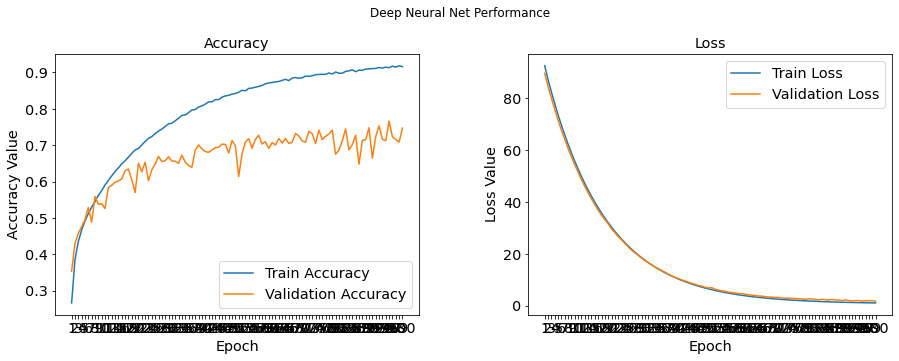

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,100+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")